In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
BASE_DIR = "/Users/akshatha/GeorgakopoulosSoaresLab/g4_analysis"
SPECIES_DATA = f"{BASE_DIR}/results/species_data.csv"
G4_PATH = f"{BASE_DIR}/results/g4hunter_g4_distribution.csv"

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'    

# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

In [18]:
# read species data
df_species = pd.read_csv(f"{BASE_DIR}/results/species_data.csv")
df_species = df_species[["Accession", "Genome Size", "GC Percentage", "Taxa"]]
df_species = df_species.replace('na', np.nan)
df_species["GC Percentage"] = df_species["GC Percentage"].astype(float)
df_species["Genome Size"] = df_species["Genome Size"].astype(float)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
df_species.head()

,Accession,Genome Size,GC Percentage,Taxa,Domain
0,GCF_900002385.2,23043114.0,21.5,protozoa,Eukaryota
1,GCF_900458895.1,2522243.0,36.0,bacteria,Bacteria
2,GCA_000002765.3,23292622.0,19.0,protozoa,Eukaryota
3,GCA_000002515.1,10689156.0,38.5,fungi,Eukaryota
4,GCA_000006605.1,2476822.0,61.0,bacteria,Bacteria


In [19]:
# read g4 data
df_g4 = pd.read_csv(G4_PATH)
df_g4 = df_g4[["accession", "g4_count", "total_g4_length"]]
df_g4 = df_g4.rename(columns={"accession": "Accession"})
df_g4["g4_count"] = df_g4["g4_count"].astype(float)
df_g4["total_g4_length"] = df_g4["total_g4_length"].astype(float)
# merge with species data
df_g4 = pd.merge(df_g4, df_species, on="Accession")
df_g4["G4 Density (per Mb)"] = df_g4["g4_count"] / df_g4["Genome Size"] * 1000000
df_g4["GC Corrected G4 Density (per Mb)"] = df_g4["G4 Density (per Mb)"] / (df_g4["GC Percentage"] / 50)
df_g4.head()

# filter out metagenomes and other taxa as they are not relevant for domain level analysis
df_g4 = df_g4[df_g4["Taxa"] != "metagenomes"]
df_g4 = df_g4[df_g4["Taxa"] != "other"]

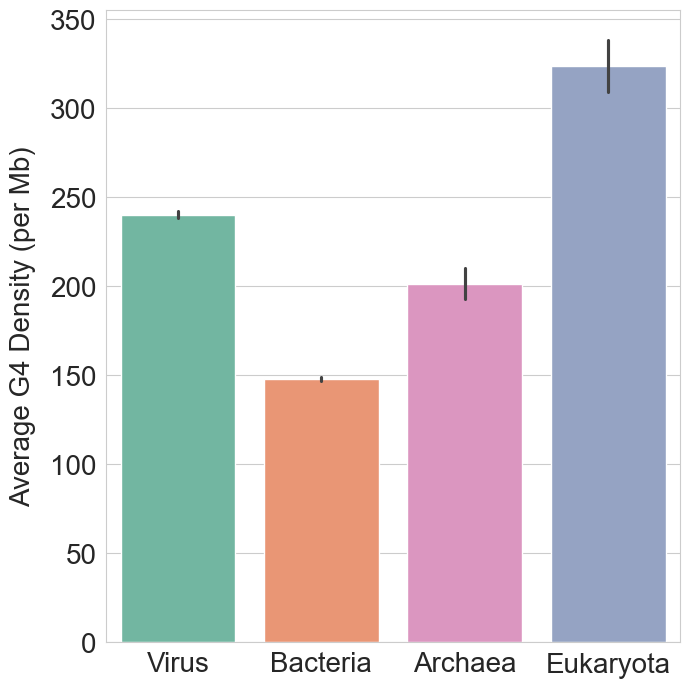

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))

# add standard error bars
sns.barplot(
    x="Domain",
    y="G4 Density (per Mb)",
    data=df_g4,
    hue="Domain",
    palette=color_map,
    order=["Virus", "Bacteria", "Archaea", "Eukaryota"],
    errorbar='se'
)

# formatting
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("")
plt.ylabel("Average G4 Density (per Mb)", fontsize=20, labelpad=10)
plt.tight_layout()

plt.savefig(f"{BASE_DIR}/plots/g4_density_domain_g4hunter.png")

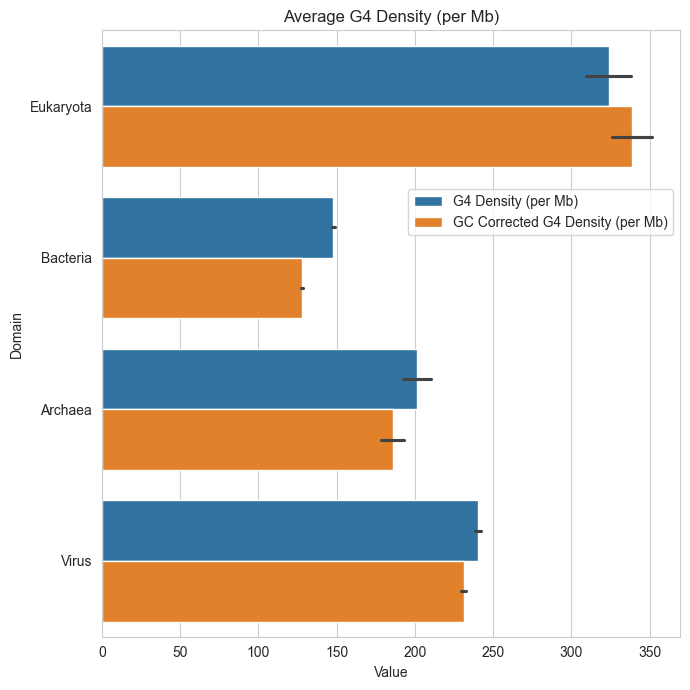

In [25]:
sns.set_style("whitegrid")
plt.figure(figsize=(7, 7))
df = df_g4[["Domain", "G4 Density (per Mb)", "GC Corrected G4 Density (per Mb)"]]
tidy = df.melt(id_vars='Domain').rename(columns=str.title)
sns.barplot(
    x="Value", 
    y="Domain", 
    hue='Variable',
    data=tidy,
    errorbar='se'
)
plt.legend(loc='center right', bbox_to_anchor=(1, 0.7))
plt.title("Average G4 Density (per Mb)")
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/g4_density_domain_gc_corrected_g4hunter.png", dpi=300)